# PSPNet 
(source: https://github.com/hszhao/semseg/blob/master/model)
# Inspired by Sun AI 
https://www.youtube.com/@sunairesearch
# Paper 
https://arxiv.org/pdf/1612.01105

In [2]:
!pip install gdown
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations
!gdown --id 1w5pRmLJXvmQQA5PtCbHhZc_uC4o0YbmA
!gdown --id 1V-sfLnqSuwTPgNMrqUp4HDZpqtoBH4xm
!gdown --id 1pVzjWA1C-y4TniEkc06ygRO6e4Mec0wW

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.7 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=549a29b2d0f9e3d1792c977cdd61576cbd54a867347e4f152b8a8d668b034828
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=76eec74e43438ce7b1f93f1f7150101f5b2e3d1c05ca65e286be56a8709c60fc
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import torchmetrics
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from tqdm import tqdm
from glob import glob

In [41]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std  = std
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [8]:
# https://github.com/albumentations-team/autoalbument/blob/master/examples/pascal_voc/dataset.py
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask


trainsize = 256

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.RGBShift(),
    A.Sharpen(),
    A.CoarseDropout(max_holes=5, max_height=int(384 * 0.1), max_width=int(384 * 0.1)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])


train_dataset =  PascalVOCSearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=True, transform=test_transform)

Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc
Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


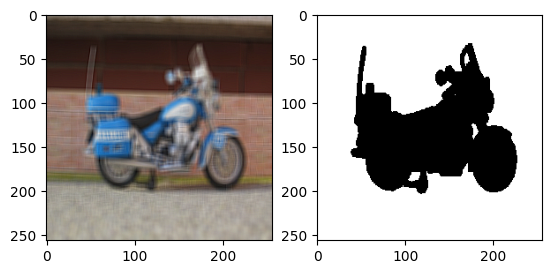

In [9]:
image, mask = train_dataset.__getitem__(800)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0)) 
plt.subplot(1, 2, 2)
plt.imshow(mask[:, :, 0], cmap='gray')

plt.show()

In [10]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, deep_base=True):
        super(ResNet, self).__init__()
        self.deep_base = deep_base
        if not self.deep_base:
            self.inplanes = 64
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
        else:
            self.inplanes = 128
            self.conv1 = conv3x3(3, 64, stride=2)
            self.bn1 = nn.BatchNorm2d(64)
            self.conv2 = conv3x3(64, 64)
            self.bn2 = nn.BatchNorm2d(64)
            self.conv3 = conv3x3(64, 128)
            self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        if self.deep_base:
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        # model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
        model_path = '/kaggle/working/resnet50_v2.pth'
        model.load_state_dict(torch.load(model_path), strict=False)
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        # model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
        model_path = './initmodel/resnet101_v2.pth'
        model.load_state_dict(torch.load(model_path), strict=False)
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        # model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
        model_path = './initmodel/resnet152_v2.pth'
        model.load_state_dict(torch.load(model_path), strict=False)
    return model

In [16]:
import torch
from torch import nn
import torch.nn.functional as F

class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)


class PSPNet(nn.Module):
    def __init__(self, layers=50, bins=(1, 2, 3, 6), dropout=0.1, classes=2, zoom_factor=8, use_ppm=True, criterion=nn.CrossEntropyLoss(ignore_index=255), pretrained=True):
        super(PSPNet, self).__init__()
        assert layers in [50, 101, 152]
        assert 2048 % len(bins) == 0
        assert classes > 1
        assert zoom_factor in [1, 2, 4, 8]
        self.zoom_factor = zoom_factor
        self.use_ppm = use_ppm
        self.criterion = criterion

        if layers == 50:
            resnet = resnet50(pretrained=pretrained)
        elif layers == 101:
            resnet = resnet101(pretrained=pretrained)
        else:
            resnet = resnet152(pretrained=pretrained)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.conv2, resnet.bn2, resnet.relu, resnet.conv3, resnet.bn3, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        #expand receptive field (Atrous Convolutions)
        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)

        fea_dim = 2048
        if use_ppm:
            self.ppm = PPM(fea_dim, int(fea_dim/len(bins)), bins)
            fea_dim *= 2
        self.cls = nn.Sequential(
            nn.Conv2d(fea_dim, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(512, classes, kernel_size=1)
        )
        if self.training:
            self.aux = nn.Sequential(
                nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(256, classes, kernel_size=1)
            )

    def forward(self, x, y=None):
        x_size = x.size()
        h = int((x_size[2] - 1) / 8 * self.zoom_factor + 1)
        w = int((x_size[3] - 1) / 8 * self.zoom_factor + 1)
    
        # Resize the input to a compatible size
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)
    
        # Proceed with the forward pass
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_tmp = self.layer3(x)
        x = self.layer4(x_tmp)
        if self.use_ppm:
            x = self.ppm(x)
        x = self.cls(x)
        if self.zoom_factor != 1:
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)
    
        if self.training:
            aux = self.aux(x_tmp)
            if self.zoom_factor != 1:
                aux = F.interpolate(aux, size=(h, w), mode='bilinear', align_corners=True)
            main_loss = self.criterion(x, y)
            aux_loss = self.criterion(aux, y)
            return x.max(1)[1], main_loss, aux_loss
        else:
            return x


In [17]:
model = PSPNet(classes=21)
x = torch.rand(4,3,257,257).float()
y = torch.rand(4,257,257).long()

a1,b1,c1 = model(x,y)
print(a1,b1,c1)

/tmp/ipykernel_23/2194596173.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=False)


tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 4,  0,  0,  ...,  0,  0,  0],
         [12,  0,  0,  ...,  0,  0,  0],
         ...,
         [19, 19, 19,  ..., 18, 11, 11],
         [19, 19, 19,  ..., 11, 11,  7],
         [19, 19, 19,  ..., 11, 11,  7]],

        [[ 4,  4,  4,  ...,  0,  0,  0],
         [ 4,  4,  4,  ...,  0,  0,  0],
         [ 4,  4,  4,  ...,  0,  0,  0],
         ...,
         [ 7,  7,  7,  ..., 14,  4,  4],
         [ 7,  7,  7,  ..., 14, 14,  4],
         [ 7,  7,  7,  ..., 14, 14, 14]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 1,  1,  1,  ..., 10, 10,  7],
         [ 1,  1,  1,  ..., 10, 10,  7],
         [ 1,  1, 11,  ..., 10,  8,  8]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [12,  0,  0,  ...,  0,  0,  0],
         [12,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 8,  4,  4,  ...,  4,  4,  4],
         [ 8,  4,  4,  ...,  4,  4, 

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32
n_workers = 2
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

model = PSPNet(layers=50, classes=21).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 70

dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=21, task="multiclass", average="macro").to(device)

acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

/tmp/ipykernel_23/2194596173.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=False)


In [23]:
aux_weight = 0.4

for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        # y = y.to(device).long()
        y = y.argmax(dim=-1)  # This will reduce the last dimension (num_classes) and give a tensor of shape [batch_size, height, width]
        y = y.to(device).long()  # Ensure the target is of the correct type
        y_hat_mask, main_loss, aux_loss = model(x, y)
        loss = main_loss + aux_weight * aux_loss
        # y_hat = model(x) #(B, C, H, W)
        # loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # y_hat_mask = y_hat.argmax(dim=1).squeeze() # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))
    if ep == 70:
        torch.save(model.state_dict(), "modelPSPNet_ep_{}.pth".format(ep))

100%|██████████| 46/46 [02:32<00:00,  3.31s/it]


EP 1, train loss = 2.267241642123363, accuracy = 0.7473135886947966, IoU = 0.22953122955507757, dice = 0.3123834219664498


100%|██████████| 46/46 [02:32<00:00,  3.31s/it]


EP 2, train loss = 1.21451029165195, accuracy = 0.8542043449448757, IoU = 0.3387019647275164, dice = 0.43335109835113983


100%|██████████| 46/46 [02:30<00:00,  3.28s/it]


EP 3, train loss = 0.9136204537146729, accuracy = 0.8764093537799648, IoU = 0.40643973396124083, dice = 0.5040189921855927


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 4, train loss = 0.7296641172607088, accuracy = 0.8938836478144745, IoU = 0.46217325346066, dice = 0.5590182236634968


100%|██████████| 46/46 [02:32<00:00,  3.30s/it]


EP 5, train loss = 0.6217973746888624, accuracy = 0.9051369213667072, IoU = 0.48230498931447013, dice = 0.5777667366741784


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 6, train loss = 0.5522972394208439, accuracy = 0.9114998051377593, IoU = 0.5240578866395794, dice = 0.6209633031178042


100%|██████████| 46/46 [02:32<00:00,  3.30s/it]


EP 7, train loss = 0.48976047475481294, accuracy = 0.9194481545458726, IoU = 0.5483569199921655, dice = 0.6421765968447826


100%|██████████| 46/46 [02:31<00:00,  3.29s/it]


EP 8, train loss = 0.4554497198980363, accuracy = 0.9230107069015503, IoU = 0.5616245178577027, dice = 0.6553512371954371


100%|██████████| 46/46 [02:32<00:00,  3.31s/it]


EP 9, train loss = 0.4101261747339384, accuracy = 0.9294055042371072, IoU = 0.5971597398890823, dice = 0.6903835925899569


100%|██████████| 46/46 [02:31<00:00,  3.29s/it]


EP 10, train loss = 0.38631162943084385, accuracy = 0.9319825719614498, IoU = 0.6062007956817502, dice = 0.6946938344038249


100%|██████████| 46/46 [02:33<00:00,  3.34s/it]


EP 11, train loss = 0.383507143278591, accuracy = 0.9304908487966151, IoU = 0.6116242610691675, dice = 0.7022642082855349


100%|██████████| 46/46 [02:30<00:00,  3.26s/it]


EP 12, train loss = 0.34455431159076794, accuracy = 0.9379484666501238, IoU = 0.6382542786702432, dice = 0.7298259826305785


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 13, train loss = 0.33009391306527974, accuracy = 0.9379110284190361, IoU = 0.6139858475799769, dice = 0.70274084024742


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 14, train loss = 0.31563814367101495, accuracy = 0.9404348887381007, IoU = 0.637191330800291, dice = 0.7243539733313472


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 15, train loss = 0.29446485215197493, accuracy = 0.9443423168255332, IoU = 0.657779860691946, dice = 0.744198025250044


100%|██████████| 46/46 [02:29<00:00,  3.25s/it]


EP 16, train loss = 0.2775358557701111, accuracy = 0.9469308908519849, IoU = 0.6735130313967095, dice = 0.7568143775554302


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 17, train loss = 0.2678701621912868, accuracy = 0.9481801625157966, IoU = 0.6724587757079328, dice = 0.7559113522044948


100%|██████████| 46/46 [02:30<00:00,  3.28s/it]


EP 18, train loss = 0.2612487103769688, accuracy = 0.947935177980225, IoU = 0.6802726078554581, dice = 0.7676858159362293


100%|██████████| 46/46 [02:29<00:00,  3.26s/it]


EP 19, train loss = 0.2475877013362822, accuracy = 0.9507751784038022, IoU = 0.6815261664937754, dice = 0.7633085459307895


100%|██████████| 46/46 [02:31<00:00,  3.30s/it]


EP 20, train loss = 0.23771777569921942, accuracy = 0.951820655272958, IoU = 0.706179884287829, dice = 0.7891890299124796


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 21, train loss = 0.23789865161226095, accuracy = 0.950278965176129, IoU = 0.699699945137149, dice = 0.7818072220015395


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 22, train loss = 0.23136019258876966, accuracy = 0.9519844683793073, IoU = 0.708149940589738, dice = 0.7898329688551647


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 23, train loss = 0.2233519871703914, accuracy = 0.9527816778975107, IoU = 0.703072545958347, dice = 0.7813768022047366


100%|██████████| 46/46 [02:33<00:00,  3.34s/it]


EP 24, train loss = 0.2130391338809592, accuracy = 0.9551571294909618, IoU = 0.7210453680304231, dice = 0.8015457098601294


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 25, train loss = 0.20691813251685576, accuracy = 0.9559973321977209, IoU = 0.7263749749934088, dice = 0.8038978759056884


100%|██████████| 46/46 [02:33<00:00,  3.35s/it]


EP 26, train loss = 0.19678174040682328, accuracy = 0.9571921138164124, IoU = 0.7381854405820044, dice = 0.8163957309201767


100%|██████████| 46/46 [02:31<00:00,  3.29s/it]


EP 27, train loss = 0.1948063028314726, accuracy = 0.9579348020214852, IoU = 0.7297456876827719, dice = 0.8064472909833564


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 28, train loss = 0.19837916426645602, accuracy = 0.9573551139544919, IoU = 0.7217272546121983, dice = 0.7990352964140678


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 29, train loss = 0.18357600149561148, accuracy = 0.9597561111867102, IoU = 0.7455719461857947, dice = 0.8227703818857995


100%|██████████| 46/46 [02:30<00:00,  3.28s/it]


EP 30, train loss = 0.17904431572377355, accuracy = 0.9600144370657498, IoU = 0.7491196413509181, dice = 0.8252544530102464


100%|██████████| 46/46 [02:32<00:00,  3.31s/it]


EP 31, train loss = 0.17796777221348767, accuracy = 0.9604390566466284, IoU = 0.7436751843801613, dice = 0.8178761480935935


100%|██████████| 46/46 [02:32<00:00,  3.31s/it]


EP 32, train loss = 0.17269621895310658, accuracy = 0.9606805297194935, IoU = 0.7507395597754932, dice = 0.8263370919097317


100%|██████████| 46/46 [02:32<00:00,  3.31s/it]


EP 33, train loss = 0.1722553673663426, accuracy = 0.96090180300624, IoU = 0.7410635273964679, dice = 0.8158720862018606


100%|██████████| 46/46 [02:31<00:00,  3.29s/it]


EP 34, train loss = 0.1619086086424322, accuracy = 0.9627851794977658, IoU = 0.7579590753127968, dice = 0.830542486222064


100%|██████████| 46/46 [02:31<00:00,  3.29s/it]


EP 35, train loss = 0.17902969271758867, accuracy = 0.9593996975591274, IoU = 0.7330881474448032, dice = 0.8087030662213518


100%|██████████| 46/46 [02:30<00:00,  3.26s/it]


EP 36, train loss = 0.18312966058163044, accuracy = 0.9588209788004557, IoU = 0.7423941724287356, dice = 0.8185219686539447


100%|██████████| 46/46 [02:30<00:00,  3.28s/it]


EP 37, train loss = 0.18025679633917052, accuracy = 0.9588727276833331, IoU = 0.733668991451055, dice = 0.810765371947992


100%|██████████| 46/46 [02:31<00:00,  3.29s/it]


EP 38, train loss = 0.17639598861092426, accuracy = 0.9599697029655748, IoU = 0.7342940972802418, dice = 0.8098500042013783


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 39, train loss = 0.16530750260327032, accuracy = 0.9618175283807223, IoU = 0.7481858577233195, dice = 0.822860189800054


100%|██████████| 46/46 [02:32<00:00,  3.32s/it]


EP 40, train loss = 0.15778880737355497, accuracy = 0.9628709365761345, IoU = 0.7684604359454796, dice = 0.8420609975121712


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 41, train loss = 0.15076289492878106, accuracy = 0.9643029805089607, IoU = 0.7697302230068894, dice = 0.8420210952967242


100%|██████████| 46/46 [02:31<00:00,  3.29s/it]


EP 42, train loss = 0.14904819754629187, accuracy = 0.964868712620657, IoU = 0.7722410097148249, dice = 0.8428041876339522


100%|██████████| 46/46 [02:31<00:00,  3.29s/it]


EP 43, train loss = 0.1403557300730481, accuracy = 0.9661533695752503, IoU = 0.7793208728722536, dice = 0.8483411164883056


100%|██████████| 46/46 [02:30<00:00,  3.28s/it]


EP 44, train loss = 0.13815446588836733, accuracy = 0.9664019711030637, IoU = 0.7785851375652793, dice = 0.8475122608122279


100%|██████████| 46/46 [02:34<00:00,  3.37s/it]


EP 45, train loss = 0.13646247054709762, accuracy = 0.9668083506855157, IoU = 0.7860330356274797, dice = 0.8556229429818242


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 46, train loss = 0.13305618593601581, accuracy = 0.9675348313128362, IoU = 0.7917910221495915, dice = 0.8594401257285655


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 47, train loss = 0.1333893826587604, accuracy = 0.9675526231364474, IoU = 0.7849187968207187, dice = 0.8532551820160913


100%|██████████| 46/46 [02:29<00:00,  3.25s/it]


EP 48, train loss = 0.13396976635755736, accuracy = 0.9674428828427049, IoU = 0.7883007083434225, dice = 0.8583609940575772


100%|██████████| 46/46 [02:30<00:00,  3.26s/it]


EP 49, train loss = 0.13085150295267992, accuracy = 0.9679917722451882, IoU = 0.798013267947025, dice = 0.8663835291002617


100%|██████████| 46/46 [02:31<00:00,  3.28s/it]


EP 50, train loss = 0.1260816884822533, accuracy = 0.9687548680383651, IoU = 0.7977635990726492, dice = 0.8642564588557176


100%|██████████| 46/46 [02:30<00:00,  3.28s/it]


EP 51, train loss = 0.12476197919233249, accuracy = 0.96902674273715, IoU = 0.7965351278013219, dice = 0.8622083543428306


100%|██████████| 46/46 [02:32<00:00,  3.31s/it]


EP 52, train loss = 0.12519302862426623, accuracy = 0.9690649007838932, IoU = 0.7978422094563968, dice = 0.8646585172642776


100%|██████████| 46/46 [02:29<00:00,  3.26s/it]


EP 53, train loss = 0.12139761643331559, accuracy = 0.969796509364915, IoU = 0.8093232352876923, dice = 0.8748133420292797


100%|██████████| 46/46 [02:31<00:00,  3.30s/it]


EP 54, train loss = 0.12096197292452952, accuracy = 0.969597300545114, IoU = 0.7991048540573954, dice = 0.8646182056333198


100%|██████████| 46/46 [02:34<00:00,  3.37s/it]


EP 55, train loss = 0.12102493261053263, accuracy = 0.9696512489370961, IoU = 0.7954512303644191, dice = 0.8606236029843815


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 56, train loss = 0.12091557144141588, accuracy = 0.9698813919161187, IoU = 0.8024800221125284, dice = 0.8668999782676905


100%|██████████| 46/46 [02:31<00:00,  3.30s/it]


EP 57, train loss = 0.14122323296923456, accuracy = 0.9657342945291696, IoU = 0.7807269624022187, dice = 0.8493174307984732


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 58, train loss = 0.16426661496605377, accuracy = 0.9616563730552549, IoU = 0.7510661544695578, dice = 0.8232388226060919


100%|██████████| 46/46 [02:31<00:00,  3.29s/it]


EP 59, train loss = 0.17052265138573985, accuracy = 0.9607497671914231, IoU = 0.7450266815925557, dice = 0.8193501927813546


100%|██████████| 46/46 [02:30<00:00,  3.26s/it]


EP 60, train loss = 0.19905839673156947, accuracy = 0.9535891944593419, IoU = 0.7110913561992958, dice = 0.7894498233586713


100%|██████████| 46/46 [02:30<00:00,  3.27s/it]


EP 61, train loss = 0.22643863242832038, accuracy = 0.9472886180617118, IoU = 0.6818692501776856, dice = 0.7634083602597804


100%|██████████| 46/46 [02:32<00:00,  3.31s/it]


EP 62, train loss = 0.21388641634925468, accuracy = 0.9512988026024866, IoU = 0.6914089051752143, dice = 0.7704919531045715


100%|██████████| 46/46 [02:34<00:00,  3.36s/it]


EP 63, train loss = 0.1616979006861077, accuracy = 0.9620807216467102, IoU = 0.7405610918347302, dice = 0.8118545312047656


100%|██████████| 46/46 [02:29<00:00,  3.25s/it]


EP 64, train loss = 0.13416838645935059, accuracy = 0.9670930143262519, IoU = 0.7744455142099349, dice = 0.843879064901279


100%|██████████| 46/46 [02:32<00:00,  3.32s/it]


EP 65, train loss = 0.12568701433190882, accuracy = 0.9688704235306203, IoU = 0.7915008986582521, dice = 0.8588011551424454


100%|██████████| 46/46 [02:30<00:00,  3.26s/it]


EP 66, train loss = 0.12182556442875679, accuracy = 0.9694351133753042, IoU = 0.795094276386532, dice = 0.8607017456508074


100%|██████████| 46/46 [02:29<00:00,  3.26s/it]


EP 67, train loss = 0.11565549940359397, accuracy = 0.9705388956382627, IoU = 0.804704231968343, dice = 0.8690135817710167


100%|██████████| 46/46 [02:31<00:00,  3.30s/it]


EP 68, train loss = 0.1143210866167897, accuracy = 0.9707600536242209, IoU = 0.8024954111849676, dice = 0.8668180752973087


100%|██████████| 46/46 [02:31<00:00,  3.29s/it]


EP 69, train loss = 0.11243560055240256, accuracy = 0.9711764291987393, IoU = 0.8115508185058343, dice = 0.8751817453102987


100%|██████████| 46/46 [02:31<00:00,  3.29s/it]


EP 70, train loss = 0.11156988754624227, accuracy = 0.9712781127684754, IoU = 0.8025258075995524, dice = 0.8673733417453662


In [71]:
import torch
from tqdm import tqdm

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy_function(preds, targets):
    # Ensure predictions and targets have the same shape
    if preds.dim() == 4 and targets.dim() == 4:
        # If targets are in (N, H, W, C), permute to (N, C, H, W)
        if targets.shape[-1] == preds.shape[1]:
            targets = targets.permute(0, 3, 1, 2)

        # Convert predictions and targets to class indices
        preds = torch.argmax(preds, dim=1)  # Convert preds to (N, H, W)
        targets = torch.argmax(targets, dim=1) if targets.dim() == 4 else targets  # Convert targets if one-hot

    # Flatten tensors for comparison
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()

    # Compute accuracy
    acc = (preds_flat == targets_flat).sum().float() / targets_flat.numel()
    return acc

# Unnormalize transformation for visualization
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# Set model to evaluation mode
model.eval()

# Initialize meters for tracking metrics during testing
test_loss_meter = AverageMeter()
test_accuracy_meter = AverageMeter()
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()

with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()  # Move input to device
        y = y.to(device)          # Move target to device

        # Ensure target (y) is an integer tensor
        if y.dim() == 4 and y.shape[-1] > 1:  # If one-hot encoded
            y = y.permute(0, 3, 1, 2)  # Convert (N, H, W, C) -> (N, C, H, W)
            y = torch.argmax(y, dim=1)  # Convert one-hot to class indices (N, H, W)
        y = y.long()  # Ensure integer type

        # Forward pass
        y_hat_mask = model(x)  # Output logits: (N, C, H, W)

        # Convert logits to class indices
        y_hat_mask = torch.argmax(y_hat_mask, dim=1)  # (N, H, W)

        # Compute metrics
        dice_score = dice_fn(y_hat_mask, y)  # Ensure (N, H, W)
        iou_score = iou_fn(y_hat_mask, y)
        accuracy = accuracy_function(y_hat_mask, y)

        # Update meters
        test_accuracy_meter.update(accuracy.item(), n)
        test_iou_meter.update(iou_score.item(), n)
        test_dice_meter.update(dice_score.item(), n)


# Print out the final test results
print("accuracy = {:.4f}, IoU = {:.4f}, dice = {:.4f}".format(
    test_accuracy_meter.avg, test_iou_meter.avg, test_dice_meter.avg
))

100%|██████████| 46/46 [01:57<00:00,  2.56s/it]

accuracy = 0.8953, IoU = 0.4688, dice = 0.5630


background
dog


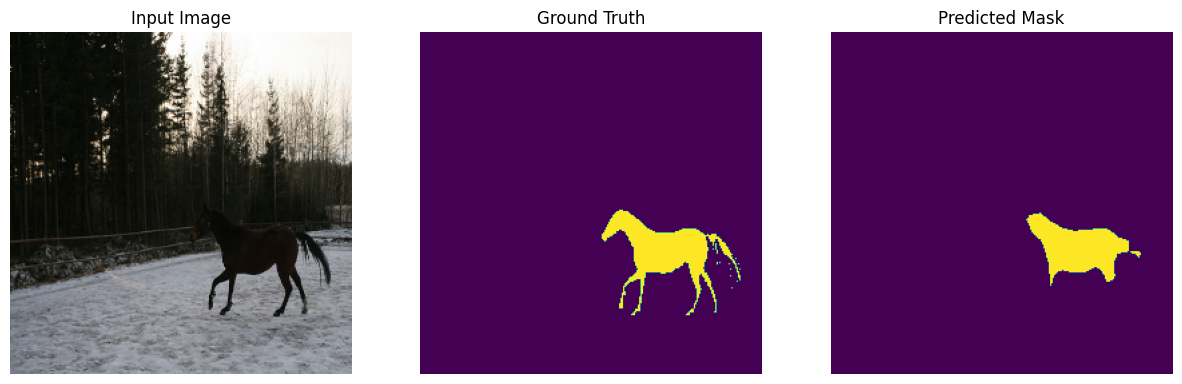

background
person


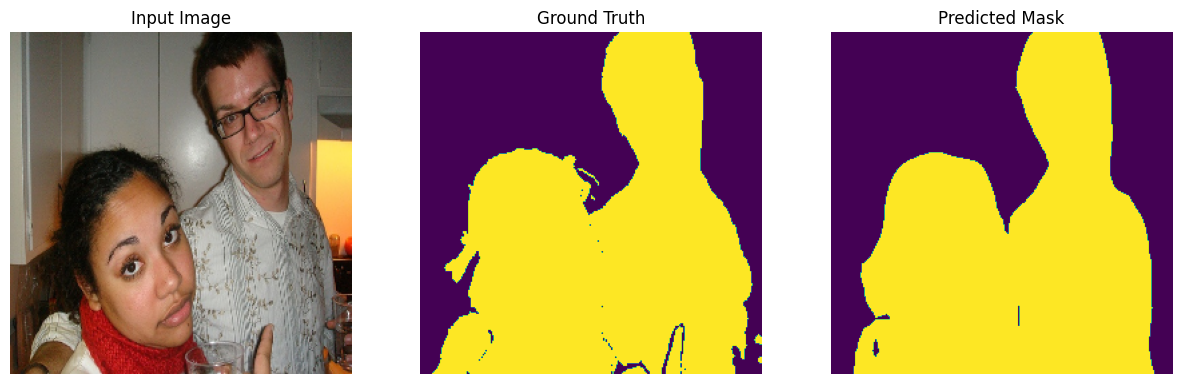

background
diningtable


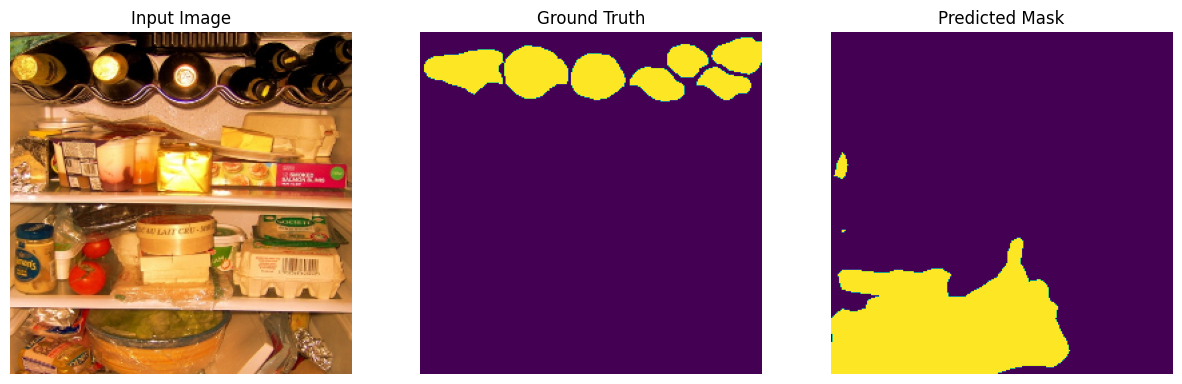

background
train


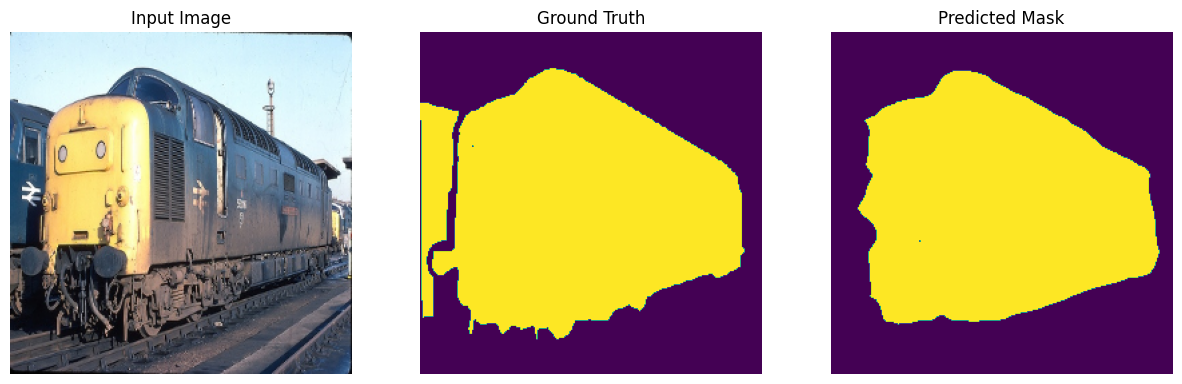

background
train


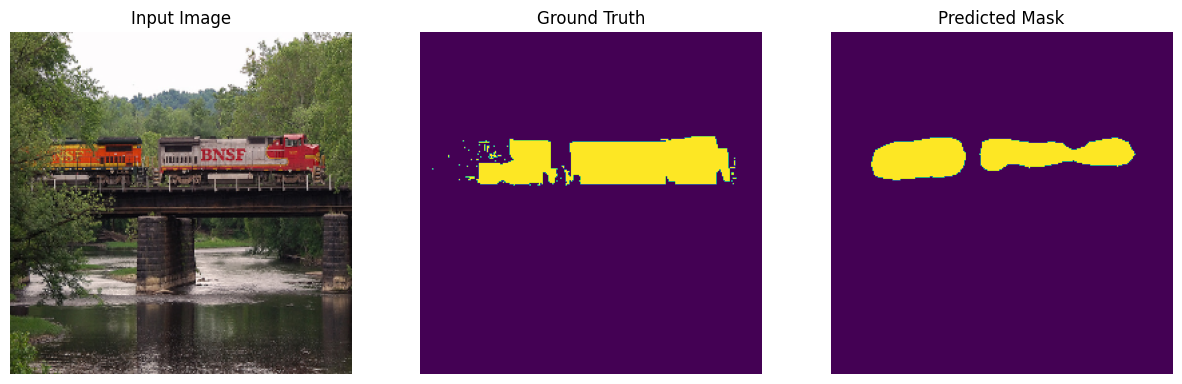

background
bird


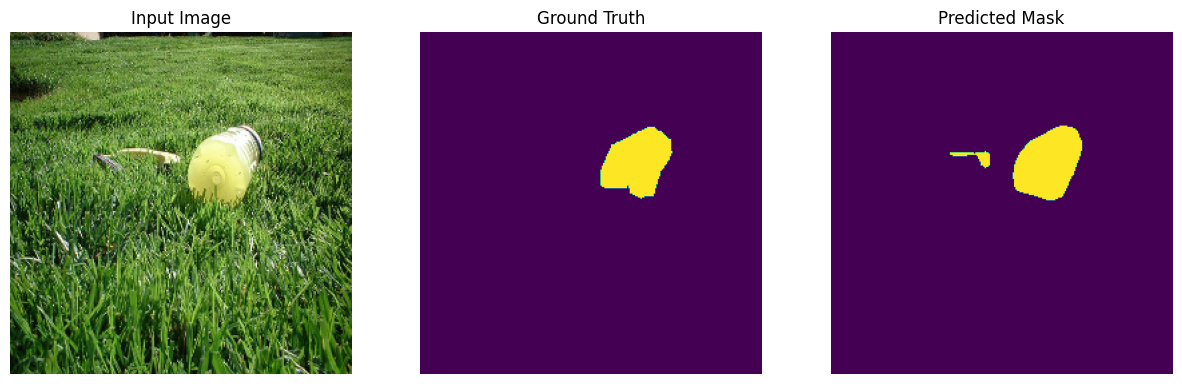

background
boat


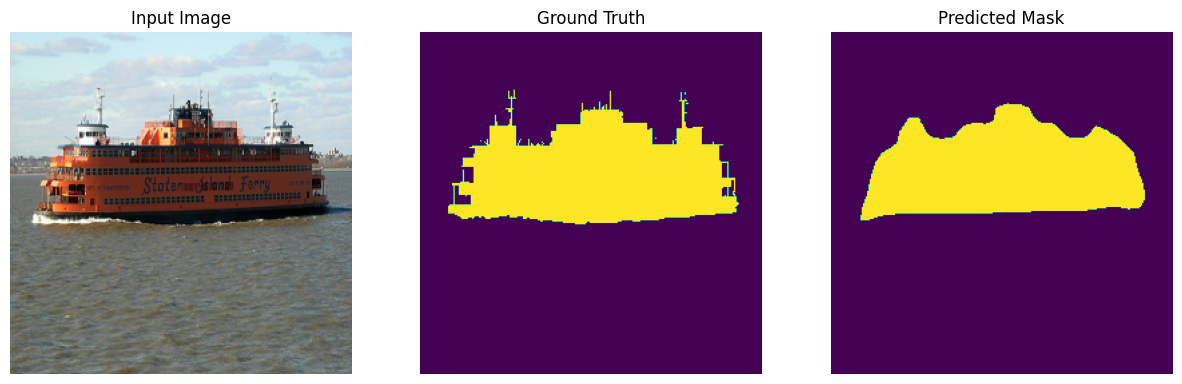

background
bicycle
motorbike
person


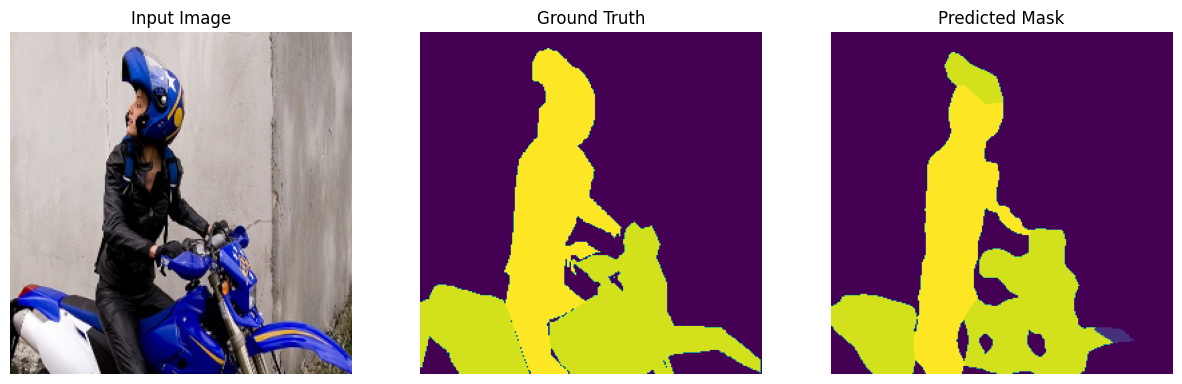

background
bicycle
person


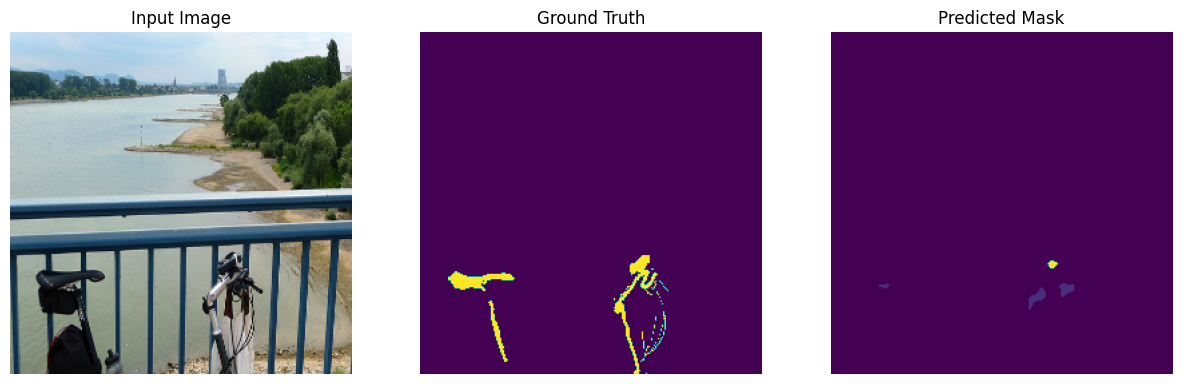

background
person


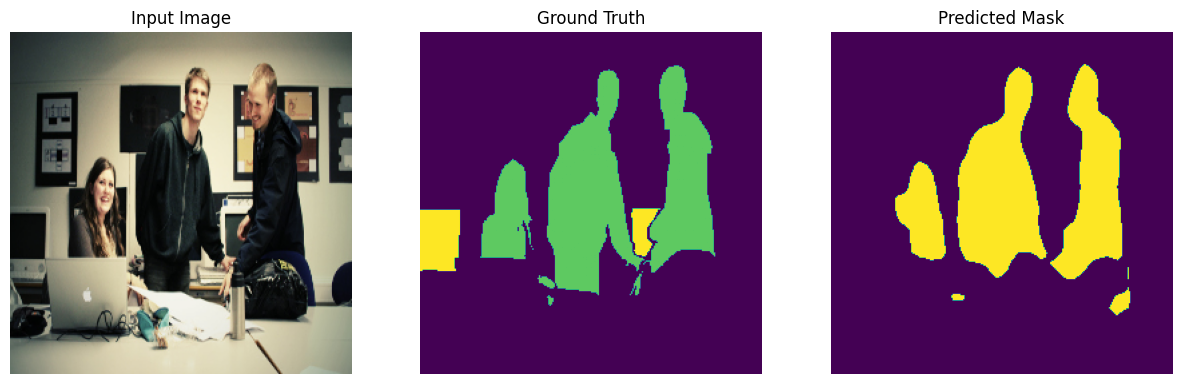

background


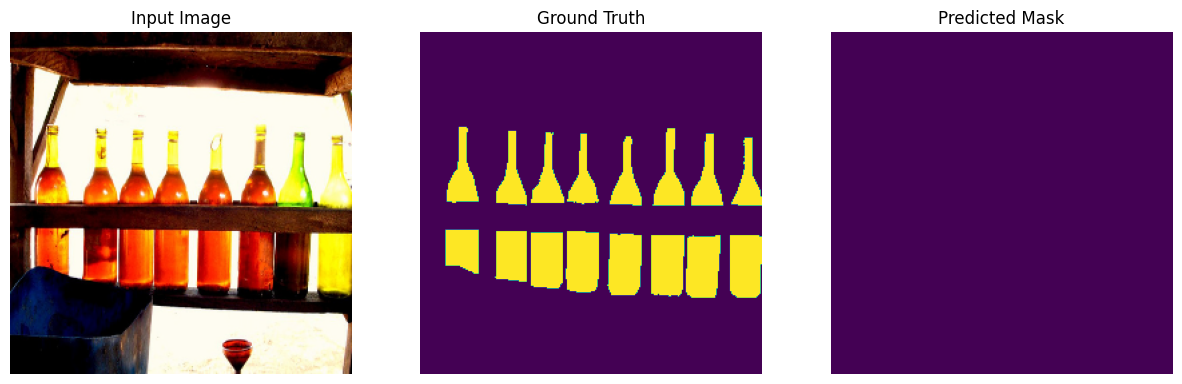

background
person


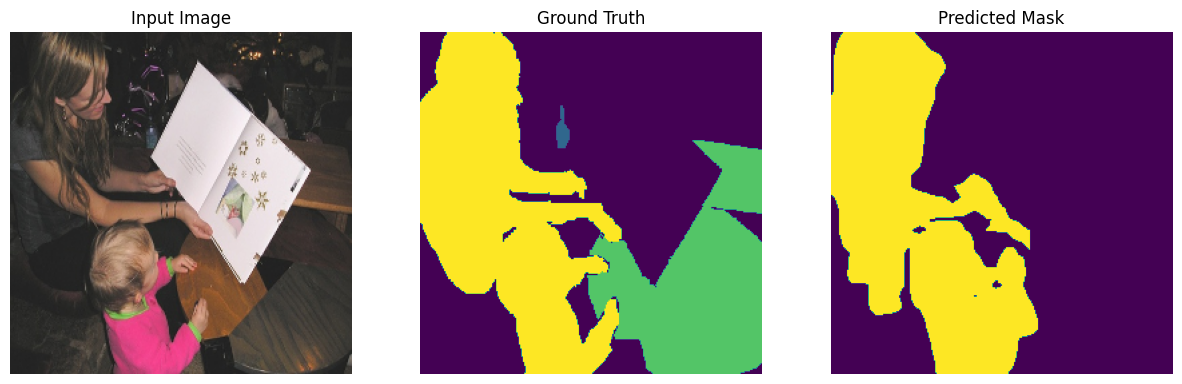

background
bicycle
car
person


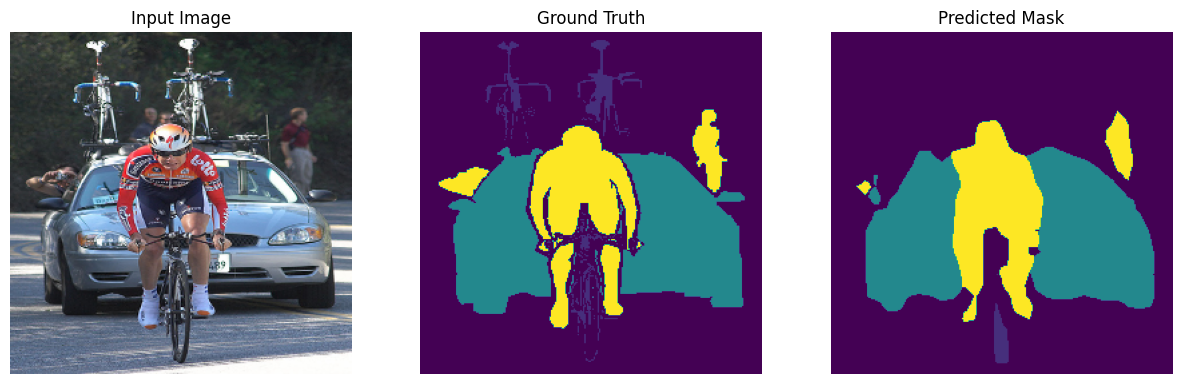

background
car
motorbike


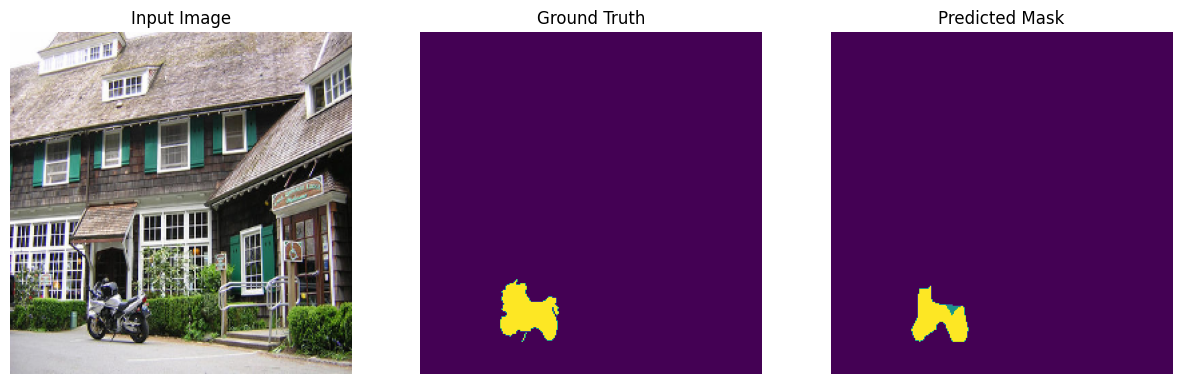

background
boat


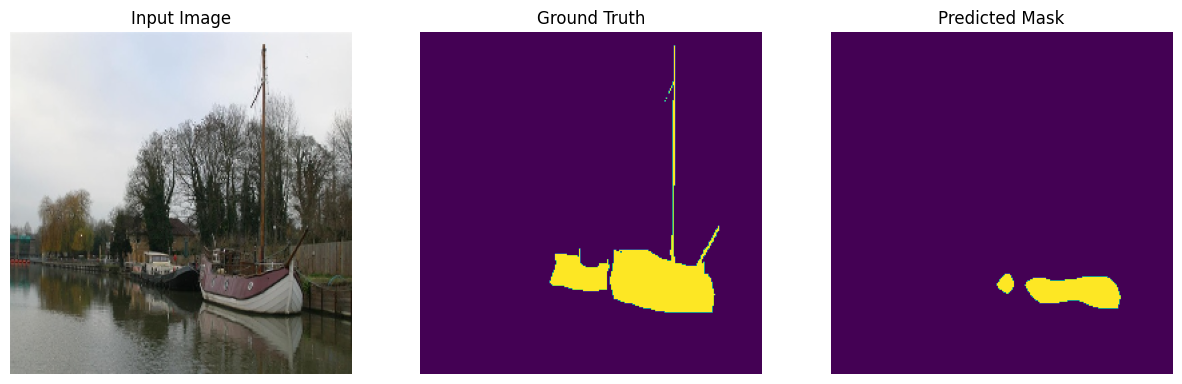

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

for i in range(15):
    # Randomly select an image and its ground truth from the test dataset
    id = random.randint(0, len(test_dataset) - 1)
    
    with torch.no_grad():
        model.eval()
        x, y = test_dataset.__getitem__(id)
        x = x.unsqueeze(0).to(device)  # Add batch dimension
        y_predict = model(x).argmax(dim=1).squeeze().cpu().numpy()  # Get predicted mask (2D array)
        
        # Print class labels for the predicted mask (if any)
        for class_id in np.unique(y_predict):
            print(VOC_CLASSES[class_id])

    # Convert the input image to a numpy array for visualization (if it's a tensor)
    x = x.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C) for RGB
    
    # Convert ground truth (if y is one-hot encoded, apply argmax to get the class labels)
    ground_truth = y.squeeze().cpu().numpy()  # (H, W, 21) -> (H, W)
    ground_truth = np.argmax(ground_truth, axis=-1)  # Apply argmax to reduce to (H, W)
    
    # Define the mean and std values used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Unnormalize: multiply by std and add mean for each channel
    unnormalized_image = x * std + mean  # Unnormalize the image

    # Clip values to [0, 1] to make sure they are within the valid range for displaying
    unnormalized_image = np.clip(unnormalized_image, 0, 1)
    
    # Plot the input image, ground truth, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Input Image (unnormalized)
    axes[0].imshow(unnormalized_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Ground Truth (2D array with class labels)
    axes[1].imshow(ground_truth)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")
    
    # Predicted Mask (2D array with class labels)
    axes[2].imshow(y_predict)
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()
